In [16]:
import os
import time
import pandas as pd
import numpy as np
import datetime
import pymysql
from sqlalchemy import create_engine
import FinanceDataReader as fdr
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf
import warnings
warnings.filterwarnings('ignore')

# make_train_data

In [ ]:
lst_code=[]
IF = open("code_list.txt", 'r')
for line in IF:
    code = line.strip('\n').split('\t')
    lst_code.append(code[0])
    
IF.close()

db_dsml = pymysql.connect(
    host = 'localhost', 
    port = 3306, 
    user = 'stock_user', 
    passwd = 'bigdata', 
    db = 'refined_stock', 
    charset = 'utf8'
)
cursor = db_dsml.cursor()

result = []

for code in tqdm(lst_code):
    sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date
                    BETWEEN '2017-11-01' AND '2020-12-31'
                    '''.format(code)
    
    stock = pd.read_sql(sql=sql_query, con=db_dsml)
    date_list = stock['Date']
    next_change_list = stock['Next Change']
    stock['trading_value'] = stock['Close'] * stock['Volume']
    
    stock = stock[['Open', 'High', 'Low', 'Close', 'MA5', 'MA20', 'MA60', 'MA120', 
                   'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
                   'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD', # scaling 필요 정보 24개
       'Volume','trading_value',
       'MFI', 'ADI', 'OBV',
       'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
       'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST',
       'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
       'WR', 'AO', 'ROC', 'PPO', 'PVO']]
    lst_stock=stock.values.tolist()

    
    # 스케일링
    scaled_stock_list=[]
    for i , row in enumerate(lst_stock):
        prev_close = lst_stock[i-1][3]
        prev_parabolic = lst_stock[i-1][21]
        scaled_inform=[]
        non_scaled_inform = row[24:]
        
        for value in row[:24]:
            scaled_inform.append( value / prev_close )
        
        scaled_stock_list.append(scaled_inform + non_scaled_inform)
    
        # 10일치 만들기
        
    for ii, (row2, date, next_change) in enumerate(zip(scaled_stock_list, date_list, next_change_list)):
        
        if (ii < 9) and next_change == None :
            continue
    
        if date <= pd.to_datetime('2018-01-01'):
            continue
        Close, MA5, MA20, MA60, MA120, Parabolic_SAR, trading_value = row2[3],row2[4],row2[5],row2[6],row2[7], row2[21],row2[25]
        
#         next_change = int(next_change >= 0.05)
        
        if trading_value >= 1000000000 :
            
            data_10_days = scaled_stock_list[ii-9:ii+1]
            day_10 = [date, code]

            for rows in data_10_days:
                day_10 += rows
            day_10 += [next_change]   
            result.append(day_10)

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1538/1561 [02:49<00:02,  9.60it/s]

In [17]:
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,...,543,544,545,546,547,548,549,550,551,552
0,2018-01-02,050120,0.992710,1.001215,0.980559,0.980559,0.995140,1.022418,1.010875,1.048319,...,0.617452,22.359457,45.645031,73.684211,-26.315789,1259.470588,44.785276,6.240212,42.055995,-0.004237
1,2018-01-03,050120,1.001239,1.288724,1.000000,1.257745,1.059480,1.054399,1.034428,1.070012,...,0.606881,24.610359,44.585678,72.709552,-27.290448,1435.352941,44.171779,7.162125,36.424051,0.072340
2,2018-01-04,050120,0.933005,1.241379,0.841379,1.000000,0.881773,0.848030,0.825057,0.851429,...,0.691669,27.889028,46.010170,74.714519,-25.285481,1988.647059,53.098420,8.403905,42.406238,-0.031746
3,2018-01-05,050120,1.044335,1.295567,1.000000,1.172414,0.955665,0.866601,0.830361,0.853654,...,0.605418,28.942646,46.865744,67.927632,-32.072368,2473.205882,51.177200,8.920744,34.040815,0.053279
4,2018-01-08,050120,1.000000,1.025210,0.857143,0.894958,0.855798,0.749370,0.711261,0.729048,...,0.670468,30.838866,48.767220,78.618421,-21.381579,2793.382353,26.600985,9.655550,27.636400,-0.089494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519418,2020-10-15,000540,1.000000,1.075472,0.977358,1.007547,0.965660,0.947075,0.881667,0.900645,...,0.876993,19.897273,44.048225,59.668508,-40.331492,280.632353,16.733068,4.226044,3.531387,-0.040956
519419,2020-10-16,000540,1.000000,1.063670,0.990637,1.016854,0.973783,0.948502,0.877559,0.894788,...,0.462853,18.900527,36.156053,46.408840,-53.591160,280.470588,14.460285,4.052309,18.909953,0.021352
519420,2020-10-19,000540,1.007366,1.016575,0.963168,1.016575,0.976059,0.941805,0.865684,0.881062,...,0.607610,18.778719,37.700278,53.038674,-46.961326,274.500000,8.301887,4.041357,13.194950,-0.017422
519421,2020-10-20,000540,1.007246,1.054348,0.990942,1.039855,0.990217,0.936504,0.854831,0.867829,...,0.157101,17.896023,33.528939,45.714286,-54.285714,285.000000,5.617978,3.840621,8.950868,0.008865


In [18]:
np.save('/project/dsml2022/gksmf457/team_project/4th_scaled_condition_X.npy', result)

# make_test_data

In [19]:
lst_code=[]
IF = open("code_list.txt", 'r')
for line in IF:
    code = line.strip('\n').split('\t')
    lst_code.append(code[0])
    
IF.close()

db_dsml = pymysql.connect(
    host = 'localhost', 
    port = 3306, 
    user = 'stock_user', 
    passwd = 'bigdata', 
    db = 'refined_stock', 
    charset = 'utf8'
)
cursor = db_dsml.cursor()

result = []

for code in tqdm(lst_code):
    sql_query = '''
                    SELECT *
                    FROM stock_{}
                    WHERE Date
                    BETWEEN '2020-11-01' AND '2021-12-31'
                    '''.format(code)
    
    stock = pd.read_sql(sql=sql_query, con=db_dsml)
    date_list = stock['Date']
    next_change_list = stock['Next Change']
    stock['trading_value'] = stock['Close'] * stock['Volume']
    
    stock = stock[['Open', 'High', 'Low', 'Close', 'MA5', 'MA20', 'MA60', 'MA120', 
                   'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
                   'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD', # scaling 필요 정보 24개
       'Volume','trading_value',
       'MFI', 'ADI', 'OBV',
       'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
       'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST',
       'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
       'WR', 'AO', 'ROC', 'PPO', 'PVO']]
    lst_stock=stock.values.tolist()

    
    # 스케일링
    scaled_stock_list=[]
    for i , row in enumerate(lst_stock):
        prev_close = lst_stock[i-1][3]
        prev_parabolic = lst_stock[i-1][21]
        scaled_inform=[]
        non_scaled_inform = row[24:]
        
        for value in row[:24]:
            scaled_inform.append( value / prev_close )
        
        scaled_stock_list.append(scaled_inform + non_scaled_inform)
    
        # 10일치 만들기
        
    for ii, (row2, date, next_change) in enumerate(zip(scaled_stock_list, date_list, next_change_list)):
        
        if (ii < 9) and next_change == None :
            continue
    
        if date <= pd.to_datetime('2021-01-01'):
            continue
        Close, MA5, MA20, MA60, MA120, Parabolic_SAR, trading_value = row2[3],row2[4],row2[5],row2[6],row2[7], row2[21],row2[25]
        
#         next_change = int(next_change >= 0.05)
        
        if trading_value >= 1000000000 :
            
            data_10_days = scaled_stock_list[ii-9:ii+1]
            day_10 = [date, code]

            for rows in data_10_days:
                day_10 += rows
            day_10 += [next_change]   
            result.append(day_10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1561/1561 [01:10<00:00, 22.09it/s]


In [20]:
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,...,543,544,545,546,547,548,549,550,551,552
0,2021-01-04,050120,1.018333,1.026667,0.983333,0.985000,0.990667,0.983583,0.971583,1.118444,...,0.325487,-12.215923,37.215196,25.000000,-75.000000,-272.176471,-4.906937,-1.250108,-26.360490,-0.012456
1,2021-01-05,050120,1.001692,1.008460,0.988156,0.991540,1.004061,0.998223,0.985956,1.127453,...,0.174829,-13.452979,38.292007,15.277778,-84.722222,-286.147059,-7.345576,-1.347042,-25.730312,0.007207
2,2021-01-06,050120,1.003413,1.003413,0.981229,0.989761,1.008874,1.006741,0.994568,1.130034,...,0.301037,-13.842828,38.366142,20.833333,-79.166667,-279.411765,-6.833333,-1.352082,-20.067933,-0.051878
3,2021-01-25,050120,1.001724,1.005172,0.981034,0.982759,1.009310,1.011724,1.004770,1.135474,...,0.000000,-17.597028,31.639201,6.521739,-93.478261,-276.441176,-10.321489,-1.752051,-24.747406,-0.020755
4,2021-01-28,050120,1.000000,1.016043,0.980392,0.982175,1.008913,1.036809,1.037314,1.154308,...,0.000000,-35.206812,29.120437,11.501597,-88.498403,-553.558824,-21.140351,-4.058729,-35.283445,-0.092325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240615,2021-07-01,000540,0.998912,1.000000,0.986942,0.992383,0.997388,0.999510,0.974157,0.868961,...,1.000000,4.680636,36.383619,45.911950,-54.088050,66.720588,4.730473,0.593980,2.301118,0.004202
240616,2021-07-09,000540,1.008734,1.032751,1.000000,1.031659,0.999345,1.008843,0.989611,0.890657,...,0.000000,-3.517669,32.229542,7.103825,-92.896175,-47.279412,-4.928806,-0.432331,-18.808273,0.012673
240617,2021-07-20,000540,0.996791,0.996791,0.964706,0.971123,1.002139,0.987166,0.985668,0.893948,...,0.029085,-14.059448,57.679667,19.531250,-80.468750,-221.558824,-9.309623,-1.489294,-33.350483,-0.012687
240618,2021-10-06,000540,0.992405,0.992405,0.977215,0.981013,1.008354,1.007342,1.062152,1.102363,...,0.827273,-27.129506,42.481106,47.663551,-52.336449,-161.147059,-5.067985,-2.142894,35.273121,-0.028646


In [21]:
np.save('/project/dsml2022/gksmf457/team_project/4th_scaled_testset_condition_X.npy', result)


# learning

In [21]:
import numpy as np
import sklearn.metrics as metrics
import pickle
from xgboost import XGBRegressor # 회귀트리 모델
import xgboost as xgb

train = np.load('../team_project/4th_scaled_trainset_bollinger.npy',allow_pickle=True)

trainX=[]
trainY=[]
for row in train:
    trainX.append(row[2:-1])
    trainY.append(row[-1])
    
trainX=np.array(trainX)
trainY=np.array(trainY)

    
import numpy as np

test = np.load('../team_project/4th_scaled_testset_bollinger.npy',allow_pickle=True)


testX=[]
testY=[]
for row in test:
    testX.append(row[2:-1])
    testY.append(row[-1])
    
testX=np.array(testX)
testY=np.array(testY)



print(trainX.shape, testX.shape)

(7049, 550) (2498, 550)


# modelling

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import roc_curve

def plot_roc_curve(trainY, testY, train_pred, test_pred, train_prob, test_prob):
    from sklearn.metrics import roc_curve, roc_auc_score, f1_score, f1_score, accuracy_score, recall_score, precision_score
    
    fpr, tpr, thresholds = roc_curve(testY, test_prob) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    
    train_f1 = f1_score(trainY, train_pred)
    test_f1 = f1_score(testY, test_pred)
    
    train_recall = recall_score(trainY, train_pred)
    test_recall = recall_score(testY, test_pred)
    
    train_pre = precision_score(trainY, train_pred)
    test_pre = precision_score(testY, test_pred)  
    
    train_acc = accuracy_score(trainY, train_pred)
    test_acc = accuracy_score(testY, test_pred)
    
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(testY, test_prob),3)),fontsize=16)
    plt.legend()
    plt.show()
    print('train_f1 score: ',train_f1)
    print('test_f1 score: ',test_f1,'\n')
    
    print('train_recall score: ',train_recall)
    print('test_recall score: ',test_recall,'\n')

    print('train_pre score: ',train_pre)
    print('test_pre score: ',test_pre,'\n')
    
    print('train acc score: ',train_acc)
    print('test acc score: ',test_acc, '\n')

def get_clf_eval(testY, y_pred_test):
    confusion = confusion_matrix(testY, y_pred_test)
    accuracy = accuracy_score(testY, y_pred_test)
    precision = precision_score(testY, y_pred_test)
    recall = recall_score(testY, y_pred_test)
    F1 = f1_score(testY, y_pred_test)
    AUC = roc_auc_score(testY, y_pred_test)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))
    
    
    
    



[5]	valid_0's auc: 0.665117	valid_0's binary_logloss: 0.622676
[10]	valid_0's auc: 0.671529	valid_0's binary_logloss: 0.577423
[15]	valid_0's auc: 0.683353	valid_0's binary_logloss: 0.540625
[20]	valid_0's auc: 0.682303	valid_0's binary_logloss: 0.514818
[25]	valid_0's auc: 0.688412	valid_0's binary_logloss: 0.497971
[30]	valid_0's auc: 0.691306	valid_0's binary_logloss: 0.483853
[35]	valid_0's auc: 0.693658	valid_0's binary_logloss: 0.465953
[40]	valid_0's auc: 0.690946	valid_0's binary_logloss: 0.44485
[45]	valid_0's auc: 0.684705	valid_0's binary_logloss: 0.431292
[50]	valid_0's auc: 0.688118	valid_0's binary_logloss: 0.415186
[55]	valid_0's auc: 0.686913	valid_0's binary_logloss: 0.400623
[60]	valid_0's auc: 0.688254	valid_0's binary_logloss: 0.389624


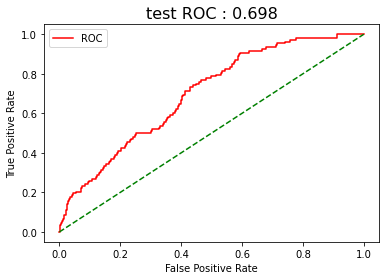

train_f1 score:  0.3452787258248009
test_f1 score:  0.14168039538714994 

train_recall score:  0.9743178170144462
test_recall score:  0.39814814814814814 

train_pre score:  0.20981679917041135
test_pre score:  0.08617234468937876 

train acc score:  0.6734288551567599
test acc score:  0.7914331465172137 

오차행렬:
 [[1934  456]
 [  65   43]]

정확도: 0.7914
정밀도: 0.0862
재현율: 0.3981
F1: 0.1417
AUC: 0.6037


In [26]:
from lightgbm import LGBMClassifier
import os
import time

start_time=time.time()

model = LGBMClassifier(
                       scale_pos_weight=20,
                       learning_rate=0.1, 
                       num_iterations = 1000, # n_estimator 랑 같은 것 같음
                       max_depth =4,
                       n_jobs=30,
                       boost_from_average=False)

trained_model = model.fit( trainX, trainY, 
          eval_set=[(testX,testY)],
          early_stopping_rounds=30, 
          verbose = 5, 
          eval_metric = 'auc')

train_pred_20 = trained_model.predict(trainX)
train_prob_20 = trained_model.predict_proba(trainX)[:, 1]

test_pred_20 = trained_model.predict(testX)
test_prob_20 = trained_model.predict_proba(testX)[:, 1]

plot_roc_curve(trainY, testY, train_pred_20, test_pred_20, train_prob_20, test_prob_20)
get_clf_eval(testY, test_pred_20)


In [24]:
pd.DataFrame(testY).value_counts()

0    2390
1     108
dtype: int64

In [99]:
TP=[]
FP=[]
TN=[]
FN=[]
for prob, pred, label in zip(test_prob_20, test_pred_20, testY):
    if pred == 1 and label ==1:
        TP.append(prob)
    elif pred == 0 and label ==1:
        FP.append(prob)
    elif pred == 0 and label ==0:
        TN.append(prob)
    elif pred == 1 and label ==0:
        FN.append(prob)

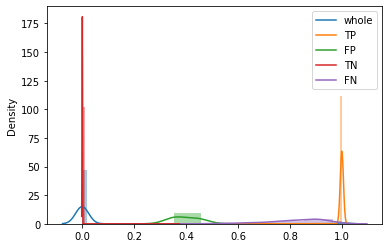

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
# fig = plt.figure(figsize(10,10))

sns.distplot(test_prob_20)
sns.distplot(TP)
sns.distplot(FP)
sns.distplot(TN)
sns.distplot(FN)
plt.legend(labels = ['whole', 'TP', 'FP', 'TN','FN'])

In [101]:
len(np.array(test_prob_20))

56060

In [102]:
sum(np.array(TP)>0.8)

2896

In [103]:
sum(np.array(FN)>0.8)

55